# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train = pd.read_csv(os.path.join(ROOT_DIR, "train_junhyeok.csv"))
test = pd.read_csv('./data/test_junhyeok.csv')

### 필요하거나 묶일 수 있는 변수 가져오기

In [3]:
# 이 셀은 한번만 클릭
train['Equipment_Dam'] = train['Equipment_Dam'].str.slice(15, 16)
train['Equipment_Fill1'] = train['Equipment_Fill1'].str.slice(17, 18)
train['Equipment_Fill2'] = train['Equipment_Fill2'].str.slice(17, 18)

test['Equipment_Dam'] = test['Equipment_Dam'].str.slice(15, 16)
test['Equipment_Fill1'] = test['Equipment_Fill1'].str.slice(17, 18)
test['Equipment_Fill2'] = test['Equipment_Fill2'].str.slice(17, 18)

In [4]:
# 새로운 영역 지정
use_train = pd.DataFrame(train['target'], columns = ['target'])
use_test = pd.DataFrame(test['Set ID'], columns = ['Set ID'])

In [5]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            train[columnname + '_Dam'] != train[columnname + '_Fill1'],
            train[columnname + '_Dam'] != train[columnname + '_Fill2'],
            train[columnname + '_Fill1'] != train[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            test[columnname + '_Dam'] != test[columnname + '_Fill1'],
            test[columnname + '_Dam'] != test[columnname + '_Fill2'],
            test[columnname + '_Fill1'] != test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [6]:
# 불일치 변수
use_train['inconsistant'] = 0
use_test['inconsistant'] = 0

# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

# 장착
for i in columnname:
    inconsistant(use_train, i, 'inconsistant', True)
    inconsistant(use_test, i, 'inconsistant', False)

In [7]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        train[j] <= 0,
        train[j] > 900
    ]
    cri2 = [
        test[j] <= 0,
        test[j] > 900
    ]
    con = [
        1, 1
    ]
    use_train['inconsistant'] = np.select(cri, con, default = use_train['inconsistant'])
    use_test['inconsistant'] = np.select(cri2, con, default = use_test['inconsistant'])

In [8]:
train['inconsistant'] = use_train['inconsistant']

In [9]:
train_noin = train[train['inconsistant'] == 0]

### inconsistant 제외 대입

In [10]:
# 유클리드 거리 계산
def euclide_distance(data, first_dot, second_dot):
    
    # 값 반환
    iwantcalculateeuclidedistance = np.array([0]*len(data))
    
    # 제곱값 더해주기
    for i, j in zip(first_dot, second_dot):
        iwantcalculateeuclidedistance += (data[i] - data[j])**2
        
    # 반환
    return iwantcalculateeuclidedistance**0.5

In [11]:
a = train_noin[[
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'Machine Tact time Collect Result_Dam',
    'Machine Tact time Collect Result_Fill1',
    'Machine Tact time Collect Result_Fill2',
    'target'
]]
a

,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,Machine Tact time Collect Result_Dam,Machine Tact time Collect Result_Fill1,Machine Tact time Collect Result_Fill2,target
0,16,14.9,8.4,14.7,1.04,0.58,1.02,10.6,12.7,3.6,12.6,12.06,3.42,11.97,58.5,55.7,19.9,Normal
1,10,21.3,4.9,21.3,1.49,0.34,1.49,10.6,13.5,3.6,13.5,12.82,3.42,12.82,65.1,56.5,19.6,Normal
2,16,14.7,8.5,14.7,1.61,0.93,1.61,10.6,13.5,3.5,13.4,12.82,3.32,12.73,76.9,58.7,19.8,Normal
3,10,21.3,8.4,21.3,1.49,0.58,1.49,10.6,13.5,3.6,13.5,12.82,3.42,12.82,70.5,57.7,19.9,Normal
4,10,9.7,4.9,9.6,0.67,0.34,0.67,10.6,13.5,3.6,13.5,12.82,3.42,12.82,88.3,89.9,19.7,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,10,17.0,5.0,17.0,1.19,0.35,1.19,10.6,13.5,3.6,13.5,12.82,3.42,12.82,56.7,51.8,19.2,Normal
40502,16,14.7,8.5,14.9,1.02,0.59,1.04,10.6,13.5,3.6,13.5,12.82,3.42,12.82,78.5,58.7,20.5,Normal
40503,16,14.2,8.2,14.3,0.99,0.57,1.00,10.6,12.9,3.6,12.9,12.25,3.42,12.25,69.5,56.2,19.7,Normal
40504,10,9.7,4.9,9.7,0.67,0.34,0.67,10.6,13.5,3.6,13.4,12.82,3.42,12.73,57.7,57.4,20.1,Normal


In [12]:
test[[
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'Machine Tact time Collect Result_Dam',
    'Machine Tact time Collect Result_Fill1',
    'Machine Tact time Collect Result_Fill2'
]].describe()

,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,Machine Tact time Collect Result_Dam,Machine Tact time Collect Result_Fill1,Machine Tact time Collect Result_Fill2
count,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000,17361.000000
mean,12.908819,14.222585,6.848396,14.227435,1.075395,0.519991,1.075103,10.611336,13.364449,3.864835,13.372288,12.660373,3.661180,12.667656,69.155101,65.773487,19.762226
std,2.998604,3.709066,1.996860,3.699321,0.323377,0.187344,0.322974,0.253994,0.523020,0.490144,0.523504,0.361201,0.456631,0.361821,14.466844,14.768444,0.889153
min,10.000000,9.600000,3.800000,9.600000,0.670000,0.260000,0.670000,8.000000,12.600000,3.200000,12.600000,11.970000,3.040000,11.970000,40.600000,40.700000,17.200000
25%,10.000000,13.100000,4.900000,13.100000,0.910000,0.340000,0.910000,10.600000,12.900000,3.600000,12.900000,12.250000,3.420000,12.250000,57.000000,55.900000,19.400000
50%,10.000000,13.200000,6.700000,13.200000,0.990000,0.530000,0.990000,10.600000,13.400000,3.600000,13.500000,12.730000,3.420000,12.730000,67.000000,57.600000,19.700000
75%,16.000000,17.000000,8.400000,17.000000,1.450000,0.600000,1.450000,10.600000,13.500000,3.900000,13.500000,12.820000,3.700000,12.820000,77.000000,75.100000,20.000000
max,16.000000,21.400000,10.600000,21.400000,2.340000,0.940000,1.630000,10.900000,17.400000,5.200000,17.400000,14.060000,4.940000,14.060000,354.800000,175.800000,101.800000


In [13]:
train_noin['cure_moving_dam'] = abs(train_noin['CURE START POSITION X Collect Result_Dam'] - train_noin['CURE END POSITION X Collect Result_Dam'])

/tmp/ipykernel_73/23908034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_moving_dam'] = abs(train_noin['CURE START POSITION X Collect Result_Dam'] - train_noin['CURE END POSITION X Collect Result_Dam'])


In [14]:
train_noin['cure_time_dam'] = train_noin['cure_moving_dam'] / train_noin['CURE SPEED Collect Result_Dam']

/tmp/ipykernel_73/2777972674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_time_dam'] = train_noin['cure_moving_dam'] / train_noin['CURE SPEED Collect Result_Dam']


In [15]:
a = pd.crosstab(train_noin['cure_time_dam'], train_noin['target']).reset_index()
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,cure_time_dam,AbNormal,Normal,total,ratio
0,6.857143,36,711,747,0.048193
1,7.200000,36,972,1008,0.035714
2,7.523810,33,855,888,0.037162
3,7.578947,3,73,76,0.039474
4,7.900000,52,1000,1052,0.049430
5,8.315789,1,82,83,0.012048
6,8.470588,72,941,1013,0.071076
7,9.294118,50,1145,1195,0.041841
8,10.285714,686,11914,12600,0.054444
9,11.285714,1287,20463,21750,0.059172


In [16]:
train_noin['cure_moving_fill2'] = abs(train_noin['CURE START POSITION X Collect Result_Fill2'] - train_noin['CURE END POSITION X Collect Result_Fill2'])

/tmp/ipykernel_73/126387981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_moving_fill2'] = abs(train_noin['CURE START POSITION X Collect Result_Fill2'] - train_noin['CURE END POSITION X Collect Result_Fill2'])


In [17]:
train_noin['cure_time_fill2'] = train_noin['cure_moving_fill2'] / train_noin['CURE SPEED Collect Result_Fill2']

/tmp/ipykernel_73/823776468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_time_fill2'] = train_noin['cure_moving_fill2'] / train_noin['CURE SPEED Collect Result_Fill2']


In [18]:
a = pd.crosstab(train_noin['cure_time_fill2'], train_noin['target']).reset_index()
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,cure_time_fill2,AbNormal,Normal,total,ratio
0,10.400000,0,1,1,0.000000
1,14.181818,19,250,269,0.070632
2,14.716981,0,36,36,0.000000
3,15.294118,35,493,528,0.066288
4,15.600000,1932,32664,34596,0.055845
5,16.250000,119,2518,2637,0.045127
6,17.333333,150,2160,2310,0.064935
7,19.500000,1,34,35,0.028571


In [19]:
train_noin['left_time'] = train_noin['Machine Tact time Collect Result_Dam'] - train_noin['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] - train_noin['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] - train_noin['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'] - train_noin['cure_time_dam']

/tmp/ipykernel_73/474826327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['left_time'] = train_noin['Machine Tact time Collect Result_Dam'] - train_noin['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] - train_noin['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] - train_noin['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'] - train_noin['cure_time_dam']


In [20]:
a = pd.crosstab(train_noin['left_time'], train_noin['target']).reset_index()
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,left_time,AbNormal,Normal,total,ratio
0,-0.085714,0,1,1,0.0
1,0.014286,0,1,1,0.0
2,0.114286,0,2,2,0.0
3,0.214286,0,1,1,0.0
4,0.314286,0,1,1,0.0
...,...,...,...,...,...
1063,210.114286,0,1,1,0.0
1064,233.314286,0,1,1,0.0
1065,248.014286,0,1,1,0.0
1066,319.114286,0,1,1,0.0


In [21]:
train_noin['fill_time'] = train_noin['Machine Tact time Collect Result_Fill1'] + train_noin['Machine Tact time Collect Result_Fill2']

/tmp/ipykernel_73/325582603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['fill_time'] = train_noin['Machine Tact time Collect Result_Fill1'] + train_noin['Machine Tact time Collect Result_Fill2']


In [22]:
train_noin['cure_time_ratio'] = round(train_noin['Machine Tact time Collect Result_Fill2'] / train_noin['fill_time'], 2)

/tmp/ipykernel_73/384838785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['cure_time_ratio'] = round(train_noin['Machine Tact time Collect Result_Fill2'] / train_noin['fill_time'], 2)


In [23]:
a = pd.crosstab(train_noin['cure_time_ratio'], train_noin['target']).reset_index()
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,cure_time_ratio,AbNormal,Normal,total,ratio
0,0.08,0,1,1,0.000000
1,0.09,0,1,1,0.000000
2,0.10,1,2,3,0.333333
3,0.11,1,1,2,0.500000
4,0.12,0,3,3,0.000000
5,0.14,10,87,97,0.103093
6,0.15,2,10,12,0.166667
7,0.16,0,22,22,0.000000
8,0.17,471,4830,5301,0.088851
9,0.18,271,3395,3666,0.073923


<Axes: xlabel='cure_time_ratio', ylabel='ratio'>

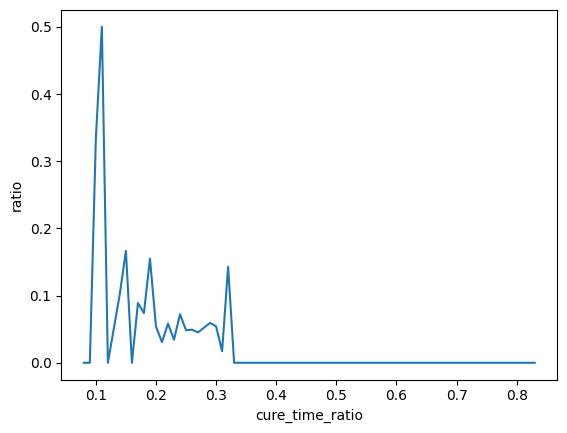

In [24]:
sns.lineplot(data = a, x = 'cure_time_ratio', y = 'ratio')

In [25]:
first_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'
] 
second_dot = [
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
]

train_noin['dist_fill_dam'] = euclide_distance(train_noin, first_dot, second_dot)

/tmp/ipykernel_73/2480591716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['dist_fill_dam'] = euclide_distance(train_noin, first_dot, second_dot)


In [26]:
a = pd.crosstab(train_noin['dist_fill_dam'], train_noin['target']).reset_index()
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a[-60:]

target,dist_fill_dam,AbNormal,Normal,total,ratio
53,65.912840,7,412,419,0.016706
54,65.933072,15,460,475,0.031579
55,65.935594,16,450,466,0.034335
56,66.027589,118,1860,1978,0.059656
57,67.077642,0,3,3,0.000000
58,67.092548,19,184,203,0.093596
59,67.107451,142,1394,1536,0.092448
60,67.114901,11,217,228,0.048246
61,67.129800,125,840,965,0.129534
62,67.144695,18,108,126,0.142857


<Axes: xlabel='dist_fill_dam', ylabel='ratio'>

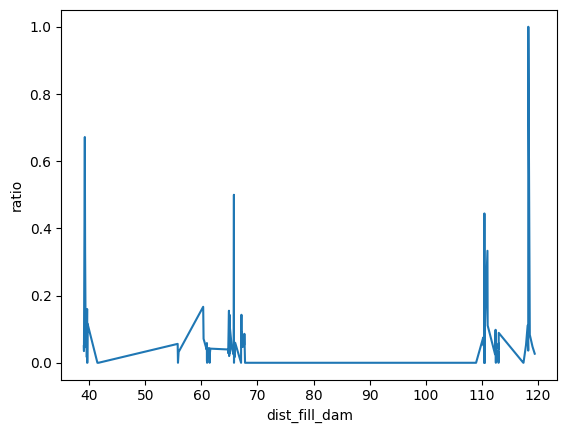

In [27]:
sns.lineplot(data = a, x = 'dist_fill_dam', y = 'ratio')

In [36]:
train_noin['rount_1st_time'] = round(train_noin['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
train_noin['rount_2nd_time'] = round(train_noin['2nd Pressure Unit Time_AutoClave'], -1)
train_noin['rount_3rd_time'] = round(train_noin['3rd Pressure Unit Time_AutoClave'], -1)
train_noin['all_time'] = round(train_noin['Chamber Temp. Unit Time_AutoClave'], -1)

/tmp/ipykernel_73/1195097108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['rount_1st_time'] = round(train_noin['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
/tmp/ipykernel_73/1195097108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_noin['rount_2nd_time'] = round(train_noin['2nd Pressure Unit Time_AutoClave'], -1)
/tmp/ipykernel_73/1195097108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [33]:
a = pd.crosstab(train_noin['rount_1st_time'], train_noin['target'])
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,AbNormal,Normal,total,ratio
rount_1st_time,,,,
0,6,56,62,0.096774
60,35,29,64,0.546875
180,22,268,290,0.075862
240,1886,34517,36403,0.051809
300,307,3286,3593,0.085444


In [34]:
a = pd.crosstab(train_noin['rount_2nd_time'], train_noin['target'])
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,AbNormal,Normal,total,ratio
rount_2nd_time,,,,
0,896,18416,19312,0.046396
60,301,3159,3460,0.086994
90,73,1874,1947,0.037494
120,975,14588,15563,0.062649
150,6,76,82,0.073171
180,5,43,48,0.104167


In [35]:
a = pd.crosstab(train_noin['rount_3rd_time'], train_noin['target'])
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,AbNormal,Normal,total,ratio
rount_3rd_time,,,,
0,2,7,9,0.222222
60,37,54,91,0.406593
90,11,92,103,0.106796
120,2048,36245,38293,0.053482
150,136,1470,1606,0.084682
180,22,279,301,0.073090
240,0,8,8,0.000000
300,0,1,1,0.000000


In [37]:
a = pd.crosstab(train_noin['all_time'], train_noin['target'])
a['total'] = a['AbNormal'] + a['Normal']
a['ratio'] = a['AbNormal'] / a['total']
a

target,AbNormal,Normal,total,ratio
all_time,,,,
0,0,4,4,0.000000
60,2,0,2,1.000000
120,0,1,1,0.000000
180,19,0,19,1.000000
210,12,12,24,0.500000
240,2,12,14,0.142857
300,7,46,53,0.132075
360,894,18416,19310,0.046297
420,0,55,55,0.000000


In [ ]:
PV/TR = n

In [ ]:
# 저장
use_train.to_csv('./data/train_0816_variable.csv', index = False)
use_test.to_csv('./data/test_0816_variable.csv', index = False)